In [1]:
import openmc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.set_printoptions(threshold = np.inf)

In [2]:
!rm *.xml *.png *.h5 *.out

# Materials

In [3]:
core = openmc.Material()
core.add_nuclide("Pu239", 100)

ht9 = openmc.Material()
ht9.add_element("Fe", 100)

na = openmc.Material()
na.add_element("Na", 100)

water = openmc.Material()
water.add_element('H', 2)
water.add_element('O', 1)

materials = openmc.Materials((core, ht9, na, water))
materials.export_to_xml()

colors = {
    core : (250, 128, 114),#'salmon',
    ht9 : 'darkgray',
    na : 'steelblue',
    water : 'darkturquoise'
}

# Geometry

## Fuel Assembly

### fuel pin

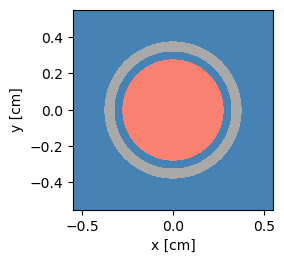

In [4]:
pellet_diameter = 5.5685 / 10

clad_inner_diameter = 6.4300 / 10
clad_outer_diameter = 7.5500 / 10

pin_cell_f2f = 8.9074 / 10
pin_pitch = 1.180 * pellet_diameter
duct_f2f = 15.710

### making cells
metal_or = openmc.ZCylinder(r = pellet_diameter / 2)
clad_ir = openmc.ZCylinder(r = clad_inner_diameter / 2)
clad_or = openmc.ZCylinder(r = clad_outer_diameter / 2)
outer_surface = openmc.model.HexagonalPrism(
    edge_length = pin_cell_f2f / 3**(.5)
)

metal_cell = openmc.Cell(fill = core, region = -metal_or)
fill_cell = openmc.Cell(fill = na, region = +metal_or & -clad_ir)
clad_cell = openmc.Cell(fill = ht9, region = +clad_ir & -clad_or)
outer_cell = openmc.Cell(fill = na, region = -outer_surface)
outer_fill = openmc.Cell(fill = na, region = +clad_or)

fuel_pin = openmc.Universe(cells = [metal_cell, fill_cell, clad_cell, outer_fill])
fuel_cell = openmc.Cell(fill = fuel_pin)
fuel_pin = openmc.Universe(cells = [fuel_cell])

### plotting
fuel_pin.plot(color_by = "material", width = [1.1, 1.1], colors = colors)
plt.show()

### fuel assembly

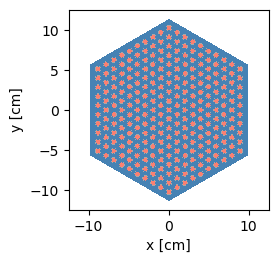

In [5]:
fuel_assembly = openmc.HexLattice()

fuel_assembly.center = (0,0)
fuel_assembly.pitch = (pin_pitch * 3**(0.5),)
fuel_assembly.outer = openmc.Universe(cells = [openmc.Cell(fill=na)])

layers = []

for i in reversed(range(1,10)):
    layers.append([fuel_pin] * (i*6))
layers.append([fuel_pin])

fuel_assembly.universes = layers

### full assembly
polygon_radius = pin_pitch * 3**(0.5) * 10
outer_hex = openmc.model.HexagonalPrism(
    edge_length = polygon_radius,
    orientation = 'y'
)

fuel_assembly_cell = openmc.Cell(fill = fuel_assembly, region = -outer_hex)

### plotting
plot_univ = openmc.Universe(cells=[fuel_assembly_cell])
plot_univ.plot(color_by = "material", width = [25 , 25], colors = colors)
plt.show()

## bounding box

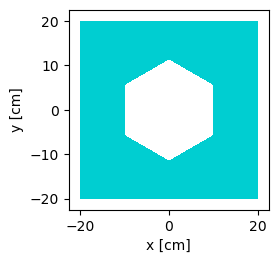

In [6]:
left = openmc.YPlane(y0 = -20, boundary_type = "vacuum")
right = openmc.YPlane(y0 = 20, boundary_type = "vacuum")
front = openmc.XPlane(x0 = 20, boundary_type = "vacuum")
back = openmc.XPlane(x0 = -20, boundary_type = "vacuum")

bounding_box = +left & -right & -front & +back & +outer_hex# & +zclin1 & +zclin2 & +zclin3 & +zclin4 & +rect_prism
bounding_cell = openmc.Cell(fill=water, region=bounding_box)

bounding_univ = openmc.Universe(cells = [bounding_cell])
bounding_univ.plot(color_by = "material", width = [45 , 45], colors = colors)
plt.show()

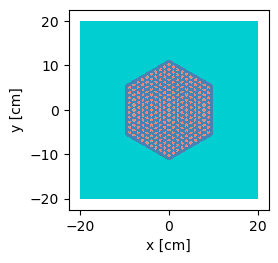

In [7]:
main_univ = openmc.Universe(cells = [bounding_cell, fuel_assembly_cell])
main_univ.plot(color_by = "material", width = [45 , 45], colors = colors)
main_cell = openmc.Cell(fill = main_univ)

geometry = openmc.Geometry([main_cell])
geometry.export_to_xml()

# Settings

In [8]:
# settings
point1 = openmc.stats.Point((0,0,0))
src1 = openmc.IndependentSource(space=point1)

settings = openmc.Settings()
settings.source = [src1]

settings.particles = 1000
settings.batches = 1000
settings.inactive = 500

settings.export_to_xml()

# Tallies

In [9]:
# tallies
## RegularMesh
mesh_len = 250
mesh_dimensions = (mesh_len, mesh_len)
mesh = openmc.RegularMesh()

size = 20
name = f"{size}".split('.')
if len(name) != 1: name = f"Spt{name[-1]}P{settings.particles}"

mesh.lower_left = (-size, -size)
mesh.upper_right = (size, size)
mesh.dimension = mesh_dimensions
mesh_filter = openmc.MeshFilter(mesh, filter_id=1)

mesh_heat = openmc.Tally()
mesh_heat.scores = ['kappa-fission']
mesh_heat.filters = [mesh_filter]

tallies = openmc.Tallies([mesh_heat])
tallies.export_to_xml()

# Running

In [10]:
!rm *.h5 *.out
openmc.run(output=False, geometry_debug=True)

rm: cannot remove '*.h5': No such file or directory
rm: cannot remove '*.out': No such file or directory


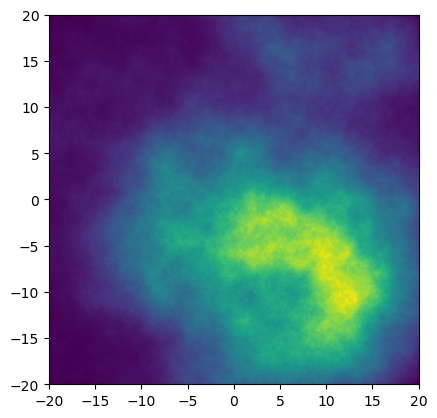

In [32]:
sp = openmc.StatePoint('statepoint.10000.h5')

for tally_key in sp.tallies:
    tally = sp.tallies[tally_key]
#    print(tally)

tally.std_dev.shape = mesh_dimensions
tally.mean.shape = mesh_dimensions

tally_plot = plt.subplot()
tally_plot.imshow(tally.mean, extent = [-20,20,-20,20])
plt.savefig(f"{name}.png", dpi=600)
plt.show()